# Illegal Logging Detection with Neural Networks
<h4>Blake Rayvid - <a href=https://github.com/brayvid>https://github.com/brayvid</a></h4>

# Start from scratch from dataset

In [ ]:
!pip install resampy

In [ ]:
# Generate X and y from audio files
import os
import numpy as np
import resampy
import librosa
import logging

logging.basicConfig(level=logging.DEBUG)

def extract_features(file_path, max_len=200):
    try:
        # Load audio file
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')

        # Generate Mel-spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=128)

        # Convert power spectrogram to dB
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

        # Pad or truncate spectrogram
        if log_mel_spectrogram.shape[1] < max_len:
            pad_width = max_len - log_mel_spectrogram.shape[1]
            log_mel_spectrogram = np.pad(log_mel_spectrogram, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            log_mel_spectrogram = log_mel_spectrogram[:, :max_len]

        return log_mel_spectrogram

    except FileNotFoundError:
        logging.error(f"File not found: {file_path}")
        return None
    except ValueError as ve:
        logging.error(f"Value error while processing file {file_path}: {ve}")
        return None
    except Exception as e:
        logging.error(f"Error processing file {file_path}: {e}")
        return None

def load_data(data_dir, max_len=200):
    features = []
    labels = []
    class_names = ['chainsaw', 'non_chainsaw']

    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)
            if file_path.endswith('.wav'):
                data = extract_features(file_path, max_len=max_len)
                if data is not None:
                    features.append(data)
                    labels.append(class_name)

    return np.array(features), np.array(labels)

# Load data
data_dir = '/content/drive/MyDrive/PROJECTS/Flatiron/Phase_4_Project/data'
max_len = 200
X, y = load_data(data_dir, max_len=max_len)

if len(X) == 0:
    logging.error("No valid features extracted.")
else:
    logging.info(f"Extracted features from {len(X)} files.")

# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

# Class names
class_names = le.classes_

In [ ]:
import pickle

# Save X and y to files using pickle
with open('/content/drive/MyDrive/PROJECTS/Flatiron/Phase_4_Project/X_chainsaw.pkl', 'wb') as f:
    pickle.dump(X, f)
with open('/content/drive/MyDrive/PROJECTS/Flatiron/Phase_4_Project/y_chainsaw.pkl', 'wb') as f:
    pickle.dump(y, f)

# Start from saved pickle files

In [5]:
import pickle

# Load X and y from pickle file
with open('/content/drive/MyDrive/PROJECTS/Flatiron/Phase_4_Project/X_chainsaw.pkl', 'rb') as f:
    X = pickle.load(f)
with open('/content/drive/MyDrive/PROJECTS/Flatiron/Phase_4_Project/y_chainsaw.pkl', 'rb') as f:
    y = pickle.load(f)

In [6]:
from sklearn.model_selection import train_test_split

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

# CNN binary classifier

In [7]:
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# Input shape: (number of samples, frequency bins, time frames, 1)
input_shape = (128, X_train.shape[2], 1)
X_train = X_train.reshape(X_train.shape[0], 128, X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], 128, X_test.shape[2], 1)

# Adjust input shape for CNN
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

model = models.Sequential()

# First convolutional layer
model.add(layers.Conv2D(32, (3, 3), input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPooling2D((2, 2)))

# Second convolutional layer
model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPooling2D((2, 2)))

# Third convolutional layer
model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPooling2D((2, 2)))

# Flatten and dense layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))

# Compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Summary of model
model.summary()

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model with early stopping
history = model.fit(X_train, y_train, epochs=50, validation_split=0.1, callbacks=[early_stopping])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 126, 198, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 126, 198, 32)      128       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 126, 198, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 99, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 61, 97, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 97, 64)       

## Evaluate CNN

7/7 [==============================] - 0s 55ms/step - loss: 0.4314 - accuracy: 0.9801
Test accuracy: 0.9800994992256165
7/7 [==============================] - 0s 10ms/step
ROC-AUC: 0.5
              precision    recall  f1-score   support

    chainsaw       0.00      0.00      0.00         4
non-chainsaw       0.98      1.00      0.99       197

    accuracy                           0.98       201
   macro avg       0.49      0.50      0.49       201
weighted avg       0.96      0.98      0.97       201



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


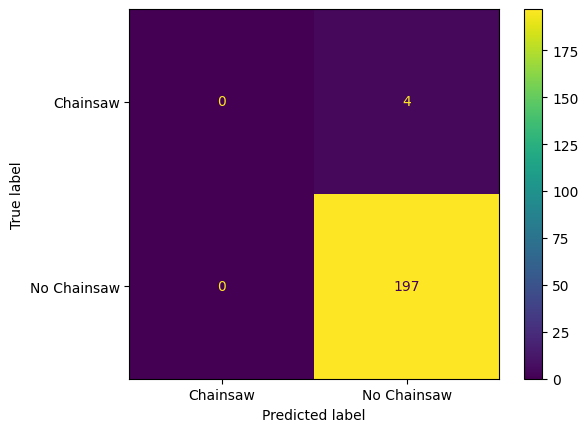

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score, classification_report, ConfusionMatrixDisplay

# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

# Get test set predictions
y_pred = np.argmax(model.predict(X_test), axis=1)

# Display ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC: {roc_auc}")

# Classification report
print(classification_report(y_test, y_pred, target_names=['chainsaw', 'non-chainsaw']))

# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Chainsaw', 'No Chainsaw'])
plt.show()

# # Plot train and validation accuracy over all epochs
# plt.plot(history.history['accuracy'], label='accuracy')
# plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.ylim([0, 1])
# plt.legend(loc='lower right')
# plt.show()

# Autoencoder outlier detector

In [3]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Normalize the data
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_normalized = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Expand dimensions to match the expected input shape for the autoencoder
X_train_normalized = np.expand_dims(X_train_normalized, axis=-1)
X_test_normalized = np.expand_dims(X_test_normalized, axis=-1)

# Define the model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 200, 1)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_squared_error')

# Summary of model
model.summary()

# Train the model on non-chainsaw data (class 1)
X_train_non_chainsaw = X_train_normalized[y_train == 1]
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_train_non_chainsaw, X_train_non_chainsaw, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 200, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 100, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 100, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 50, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 50, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 25, 128)       0

## Evaluate autoencoder

7/7 [==============================] - 1s 100ms/step
Reconstruction error threshold: 1.7402906179428097
ROC-AUC: 0.5253807106598984
              precision    recall  f1-score   support

    chainsaw       0.02      1.00      0.04         4
non-chainsaw       1.00      0.05      0.10       197

    accuracy                           0.07       201
   macro avg       0.51      0.53      0.07       201
weighted avg       0.98      0.07      0.10       201



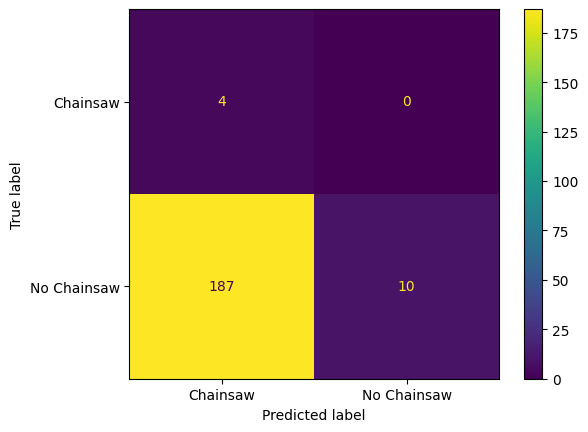

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, classification_report, ConfusionMatrixDisplay

# Predict and calculate the reconstruction error
reconstructions = model.predict(X_test_normalized)
reconstruction_errors = np.mean(np.power(np.squeeze(X_test_normalized) - np.squeeze(reconstructions), 2), axis=(1, 2))

# Determine the threshold for detecting outliers (chainsaws)
threshold = np.percentile(reconstruction_errors[y_test == 1], 95)  # 95th percentile from non-chainsaw errors
print(f"Reconstruction error threshold: {threshold}")

# Classify as chainsaw (0) if reconstruction error exceeds threshold
predictions = (reconstruction_errors > threshold).astype(int)

# Display ROC-AUC
roc_auc = roc_auc_score(y_test, predictions)
print(f"ROC-AUC: {roc_auc}")

# Classification report
print(classification_report(y_test, predictions, target_names=['chainsaw', 'non-chainsaw']))

# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, predictions, display_labels=['Chainsaw', 'No Chainsaw'])
plt.show()